In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [2]:
class ABENet(nn.Module):
    def __init__(self, N, has_key=True):
        super(ABENet, self).__init__()
        self.N = N
        
        self.fc    = nn.Linear(in_features=2*N if has_key else N, out_features=2*N)
        self.conv1 = nn.Conv1d(kernel_size=4, in_channels=1, out_channels=2, stride=1, padding=2)
        self.conv2 = nn.Conv1d(kernel_size=2, in_channels=2, out_channels=4, stride=2)
        self.conv3 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=4, stride=1)
        self.conv4 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=1, stride=1)

    def forward(self, x):
        x = torch.sigmoid( self.fc(x) )
        x = x.view(-1, 1, 2*self.N)
        x = torch.sigmoid( self.conv1(x) )
        x = torch.sigmoid( self.conv2(x) )
        x = torch.sigmoid( self.conv3(x) )
        x = torch.tanh(    self.conv4(x) )
        x = x.view(-1, self.N)
        return x

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [26]:
N = 16 # [16, 32, 64]
Alphabet = [-1, 1]
minibatch_size = 4096 # [256..4096]
A = ABENet(N, has_key=True).to(DEVICE)
B = ABENet(N, has_key=True).to(DEVICE)
E = ABENet(N, has_key=False).to(DEVICE)

In [27]:
#l1_norm = lambda P1, P: torch.mean( torch.sum( torch.abs(P1 - P), dim=1 ), dim=0 ) # mean of batch
l1_norm = nn.L1Loss()
loss_eve = l1_norm
loss_bob = l1_norm
#loss_alicebob = lambda P_bob, P_eve, P: loss_bob(P_bob, P) + (((N/2 - loss_eve(P_eve, P))**2) / ((N/2)**2))
loss_alicebob = lambda P_bob, P_eve, P: loss_bob(P_bob, P) + (((1.0 - loss_eve(P_eve, P))**2))

In [28]:
A_optimizer = optim.Adam(A.parameters(), lr=0.0008)
B_optimizer = optim.Adam(B.parameters(), lr=0.0008)
E_optimizer = optim.Adam(E.parameters(), lr=0.0008)

In [29]:
max_iter = 150000
ABs = []
Es = []

A.train()
B.train()
E.train()

for ic in range(max_iter):
    for who, num_minibatches in [('AB', 1), ('E', 2)]:
        for _ in range(num_minibatches):
            P = torch.randint(low=0, high=2, size=(minibatch_size,N), dtype=torch.float).to(DEVICE)*2-1
            K = torch.randint(low=0, high=2, size=(minibatch_size,N), dtype=torch.float).to(DEVICE)*2-1 

            C     = A(torch.cat((P, K), dim=1))
            P_bob = B(torch.cat((C, K), dim=1))
            P_eve = E(C)

            if who == 'AB':
                AB_loss = loss_alicebob(P_bob, P_eve, P)
                
                A_optimizer.zero_grad()
                B_optimizer.zero_grad()
                AB_loss.backward()
                A_optimizer.step()
                B_optimizer.step()
                
            elif who == 'E':
                E_loss  = loss_eve(P_eve, P)

                E_optimizer.zero_grad()
                E_loss.backward()
                E_optimizer.step()

    if ic % 1000 == 999:
        print("[{:6d}] AB_loss: {:2.4f} E_loss: {:2.4f}".format(ic+1, AB_loss, E_loss))
    ABs.append(AB_loss.item())
    Es.append(E_loss.item())
    if AB_loss < 0.005 and E_loss > 0.5: # AB_loss < 0.05 and E_loss > 2
        break
    

[  1000] AB_loss: 1.0022 E_loss: 0.9865


[  2000] AB_loss: 0.9279 E_loss: 0.9504


[  3000] AB_loss: 0.1135 E_loss: 0.7505


[  4000] AB_loss: 0.0354 E_loss: 0.8569


[  5000] AB_loss: 0.0158 E_loss: 0.8945


[  6000] AB_loss: 0.0083 E_loss: 0.9223


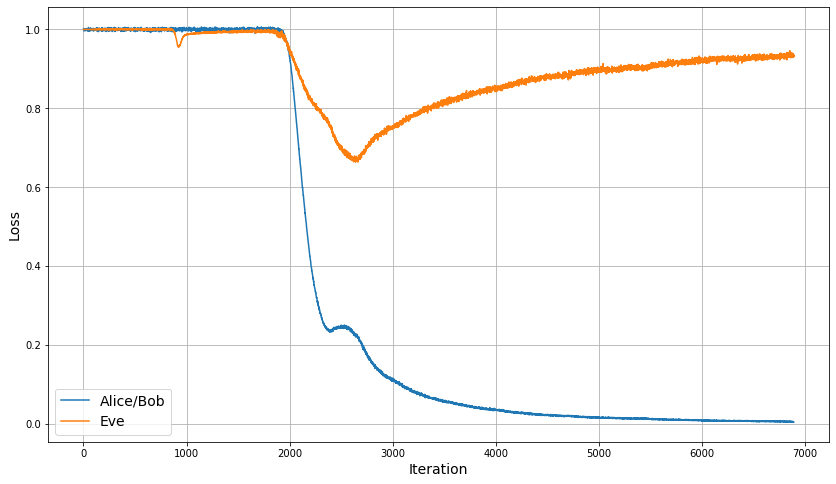

In [30]:
plt.figure(figsize=(14,8))
plt.plot(range(1, len(ABs)+1), ABs, label='Alice/Bob')
plt.plot(range(1, len(Es)+1), Es, label='Eve')
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, which='both')
plt.show()

In [31]:
with torch.no_grad():
    P = torch.randint(low=0, high=2, size=(1,N), dtype=torch.float).to(DEVICE)*2-1
    K = torch.randint(low=0, high=2, size=(1,N), dtype=torch.float).to(DEVICE)*2-1
    C = A(torch.cat((P, K), dim=1))
    D = B(torch.cat((C, K), dim=1))
    F = E(C)
    print ("P:\n", P.cpu())
    print ("K:\n", K.cpu())
    print ("A(P,K):\n", C.cpu())
    print ("B(A(P, K), K):\n", D.cpu())
    print ("E(A(P, K)):\n", F.cpu())

P:
 tensor([[-1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,
         -1.,  1.]])
K:
 tensor([[ 1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,
          1., -1.]])
A(P,K):
 tensor([[ 0.1902, -0.3510, -0.4928, -0.2155,  0.4302, -0.6774, -0.5870,  0.5898,
          0.2071, -0.6020, -0.4697, -0.2597, -0.0156,  0.4494, -0.3809,  0.4661]])
B(A(P, K), K):
 tensor([[-0.9900,  0.9971,  0.9980, -0.9989,  0.9988, -0.9989,  0.9987,  0.9975,
          0.9996,  0.9989, -0.9993, -0.9987,  0.9890, -0.9992, -0.9991,  0.9999]])
E(A(P, K)):
 tensor([[ 1.0000,  0.9999, -1.0000, -1.0000,  0.8455,  1.0000,  1.0000,  1.0000,
          0.9964, -1.0000,  1.0000,  0.9999, -1.0000,  1.0000,  1.0000,  1.0000]])


In [32]:
with torch.no_grad():
    TEST_SIZE = 50000
    B_correct = 0
    E_correct = 0
        
    for I in range(TEST_SIZE):
        P = torch.randint(low=0, high=2, size=(1,N), dtype=torch.float).to(DEVICE)*2-1
        K = torch.randint(low=0, high=2, size=(1,N), dtype=torch.float).to(DEVICE)*2-1
        C   = A(torch.cat((P, K), dim=1))
        P_b = B(torch.cat((C, K), dim=1))
        P_e = E(C)
        if torch.equal(P, P_b.round()): B_correct += 1
        if torch.equal(P, P_e.round()): E_correct += 1
    print ("B: {:.4f}".format(B_correct * 100 / TEST_SIZE))
    print ("E: {:.4f}".format(E_correct * 100 / TEST_SIZE))


B: 99.9940
E: 0.0020


In [33]:
retries = 5
es_max_iter = 20000 #250000

Best_E_loss = 10000
Best_E = None

for es in range(retries):
    
    CE = ABENet(N, has_key=False).to(DEVICE)
    CE_optimizer = optim.Adam(CE.parameters(), lr=0.0008)
    for ic in range(es_max_iter):
        P = torch.randint(low=0, high=2, size=(minibatch_size,N), dtype=torch.float).to(DEVICE)*2-1
        K = torch.randint(low=0, high=2, size=(minibatch_size,N), dtype=torch.float).to(DEVICE)*2-1 
        C     = A(torch.cat((P, K), dim=1))
        P_eve = CE(C)
        CE_loss  = loss_eve(P_eve, P)
        CE_optimizer.zero_grad()
        CE_loss.backward()
        CE_optimizer.step()
        if ic % 10000 == 9999:
            print("[{:d} - {:6d}] CE_loss: {:2.4f}".format(es+1, ic+1, CE_loss))

        if CE_loss <= 0.005:
            print ("Optimal E found!")
            break    
            
    if CE_loss.item() < Best_E_loss:
        Best_E_loss = CE_loss.item()
        Best_E = CE


[1 -  10000] CE_loss: 0.7761


[1 -  20000] CE_loss: 0.7720


[2 -  10000] CE_loss: 0.8069


[2 -  20000] CE_loss: 0.8117


[3 -  10000] CE_loss: 0.8139


[3 -  20000] CE_loss: 0.8075


[4 -  10000] CE_loss: 0.8145


[4 -  20000] CE_loss: 0.8087


[5 -  10000] CE_loss: 0.8004


[5 -  20000] CE_loss: 0.7937
